制作自己的数据集

In [1]:
# 各种依赖
import os
import torch
from torch.autograd import Variable
import torch.utils.data as data
from PIL import Image
import torchvision
import torchvision.transforms as transforms

路径定义

In [2]:
data_image_dir = os.path.abspath(os.path.join(os.getcwd(), "./data/images"))
data_annotations_dir = os.path.abspath(os.path.join(os.getcwd(), "./data/annotations"))

由于训练集和测试集的数据量是一样的，所以我打算从测试集里面分出一半做验证集

In [26]:
from copy import deepcopy

with open(os.path.join(data_annotations_dir, 'test.txt'), 'r') as fh:
# with open('test.txt', 'r') as fh:
    imgs = {}
    i = 0
    for line in fh:
        # print(line)
        line = line.strip('\n')
        # line = line.rstrip()
        words = line.split()
        name = '_'.join( words[0].split('_')[:-1] )
        # print( line )
        if name in imgs:
#             print(imgs)
            imgs[name] += 1
        else:
            imgs[name] = 1
        # break
        # i += 1
        # if i == 250:
        #     break

    # 这是把每个种的数量统计出来
    vals = deepcopy(imgs)
    # print(vals)
#     print(imgs)
#     print('i', i)
    valtxt = ''
    test1txt = ''
    fh.seek(0)
    i = 0
    for line in fh:
#         print('line', line)
#         line = line.strip('\n')
        # line = line.rstrip()
        words = line.strip('\n').split()
        # print(words)
        name = '_'.join( words[0].split('_')[:-1] )
        # print(name)
        # break
#         print(imgs[name] / 2)
#         print(name)
#         print(vals[name])
        if vals[name] > imgs[name] / 2 :
#             print(val[name])
            vals[name] -= 1
            test1txt += line
        else :
            valtxt += line
        # i += 1
        # if i > 50:         
        #     break
# print('test1txt: ', test1txt)
# test1txt

with open(os.path.join(data_annotations_dir, 'test1.txt'), 'w') as f:
    f.write(test1txt)

with open(os.path.join(data_annotations_dir, 'val.txt'), 'w') as f:
    f.write(valtxt)

print('ok!')

ok!


用 Python 的 PIL 库处理一下这个图片

In [3]:
def default_loader(path):
    return Image.open(os.path.join(data_image_dir, path)).convert('RGB')

数据集的加载

In [17]:
class MyDataset(data.Dataset):
    def __init__(self, txt, transform=None, target_transform=None, loader=default_loader):
        with open(os.path.join(data_annotations_dir, txt), 'r') as fh:
            imgs = []
            for line in fh:
#                 print(line)
                line = line.strip('\n')
                # line = line.rstrip()
                words = line.split()
                imgs.append( ( words[0], int(words[2]) - 1 ) )
            self.imgs = imgs
            self.transform = transform
            self.target_transform = target_transform
            self.loader = loader
        

    def __getitem__(self, index):
        fn, label = self.imgs[index]
        img = self.loader(fn + '.jpg')
        # print('label', label)
        if self.transform is not None:
            img = self.transform(img)
        return img,label

    def __len__(self):
        return len(self.imgs)

数据集的制作

In [21]:
transform = transforms.Compose(
    [
        transforms.Scale(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ]
)

trainset = MyDataset(txt = './trainval.txt', transform=transform)
valset = MyDataset(txt = './val.txt', transform=transform)
testset = MyDataset(txt = './test1.txt', transform=transform)

trainloader = data.DataLoader(trainset, batch_size=10,
                                          shuffle=True, num_workers=4)
valloader = data.DataLoader(valset, batch_size=10,
                                          shuffle=True, num_workers=4)
testloader = data.DataLoader(testset, batch_size=10,
                                         shuffle=False, num_workers=4)
# 0:Cat 1:Dog
classes = ('Cat', 'Dog')

把数据集取一点看看

In [20]:
iter(trainloader)

BrokenPipeError: [Errno 32] Broken pipe

In [6]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
# functions to show an image

def imshow(img):
#     img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

print(' '.join('%5s' % labels[j] for j in range(4)))

BrokenPipeError: [Errno 32] Broken pipe

定义神经网络并加载参数

In [8]:
import torchvision.models as models
import torch.nn as nn

net = models.alexnet(num_classes=2)
# net = models.densenet121(num_classes=2)

# 使用显卡数量
net = net.cuda()
# net = nn.DataParallel(net).cuda()

# 加载之前的参数
# net.load_state_dict( torch.load('densenet121_epoch40_params.pkl') )


定义一个损失函数

In [9]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

adjust Learning Rate

In [10]:
from torch.optim.lr_scheduler import StepLR
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
# print(lambda1)

Train the network

In [11]:
%%time

from torch.autograd import Variable
for epoch in range(5):  # loop over the dataset multiple times

    scheduler.step()

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # wrap them in Variable
#         inputs, labels = Variable(inputs), Variable(labels)
        inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.data[0]
        if i % 80 == 79:    # print every 80 mini-batches
            print('[%d, %5d] loss: %.4f' %
                  (epoch + 1, i + 1, running_loss / 80))
            running_loss = 0.0
            print([param_group["lr"] for param_group in optimizer.param_groups])

# print('Finished Training', time.time() - t1)

BrokenPipeError: [Errno 32] Broken pipe

用训练出来的网络对整个测试集来做预测

In [11]:
correct = 0
total = 0
for data in testloader:
    images, labels = data
    images = images.cuda()
    labels = labels.cuda()
    outputs = net(Variable(images))
    _, predicted = torch.max(outputs.data, 1)
    total += labels.size(0)
    correct += (predicted == labels).sum()

print('Accuracy of the network on the 3680 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 3680 test images: 69 %


看看其中一些图片的预测准确率

GroundTruth:    Cat   Cat   Cat   Cat   Cat   Cat   Cat   Cat   Cat   Cat


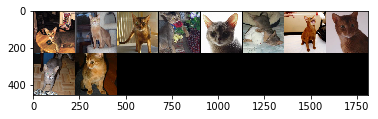

In [12]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# labels = labels.cuda()
# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(10)))

In [14]:
_, predicted = torch.max(outputs.data, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(10)))

Predicted:    Dog   Dog   Dog   Dog


看看每一种的预测结果

In [13]:
class_correct = list(0. for i in range(2))
class_total = list(0. for i in range(2))
for data in testloader:
    images, labels = data
    labels = labels.cuda()
    outputs = net(Variable(images.cuda()))
    _, predicted = torch.max(outputs.data, 1)
    c = (predicted == labels).squeeze()
    for i in range(labels.size(0)):
        label = labels[i]
        class_correct[label] += c[i]
        class_total[label] += 1


for i in range(2):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))

Accuracy of   Cat : 37 %
Accuracy of   Dog : 85 %


保存模型参数

In [12]:
torch.save(net.state_dict(), 'densenet121_epoch50_params.pkl')